In [ ]:
import tensorflow as tf

In [ ]:
import keras as tf

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from time import perf_counter

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [ ]:
import numpy as np

In [ ]:
!pip install tf-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.7/528.7 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 88.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.0/441.0 kB 40.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3120119469939723033
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14374731776
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12234929408219776441
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

# **Data preparation**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from IPython.display import Image

In [ ]:
import pathlib
path = '/content/drive/MyDrive/Colab Notebooks/Image classification/Dataset/train' #ที่อยู่ของข้อมูล
data_dir = pathlib.Path(path)

In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

2350


#**Identify the size of dataset** 

In [ ]:
import os
import PIL

data_dir = '/content/drive/MyDrive/Colab Notebooks/Image classification/Dataset/train/'
single = list(os.path.join(data_dir, f) for f in os.listdir(data_dir))
PIL.Image.open(single[1])

IsADirectoryError: ignored

In [ ]:
batch_size = 16
img_height = 180
img_width = 180

# **Train and validate dataset**

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset='training',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset='validation',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 2350 files belonging to 2 classes.
Using 1880 files for training.
Found 2350 files belonging to 2 classes.
Using 470 files for validation.


# **Class Defination**

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Normal', 'Osteoarthritis']


# **Randomly pictures to present the dataset**

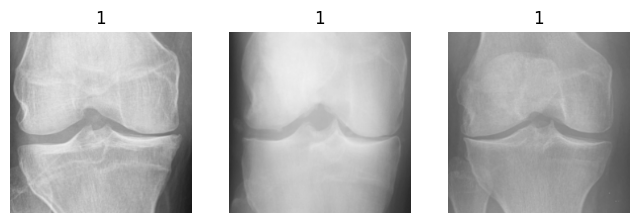

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# **Normalize layers**

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.78333336


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [ ]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# **Define model**

In [ ]:
num_classes = 2
Model = Sequential([
layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
layers.Conv2D(4, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(8, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(16, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Flatten(),
layers.Dense(32, activation='relu'),
layers.Dense(num_classes)])

# **Compile the model**

In [ ]:
Model.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 4)       112       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 4)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 8)         296       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 16)       

# **Train the model**

In [ ]:
epochs=15
history = Model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/15
118/118 [==============================] - 12s 101ms/step - loss: 0.4479 - accuracy: 0.7814 - val_loss: 0.4361 - val_accuracy: 0.7723
Epoch 2/15
118/118 [==============================] - 13s 109ms/step - loss: 0.4427 - accuracy: 0.7793 - val_loss: 0.4201 - val_accuracy: 0.7830
Epoch 3/15
118/118 [==============================] - 14s 118ms/step - loss: 0.4285 - accuracy: 0.7984 - val_loss: 0.3944 - val_accuracy: 0.8234
Epoch 4/15
118/118 [==============================] - 13s 107ms/step - loss: 0.4293 - accuracy: 0.7926 - val_loss: 0.4138 - val_accuracy: 0.8021
Epoch 5/15
118/118 [==============================] - 14s 112ms/step - loss: 0.4231 - accuracy: 0.8048 - val_loss: 0.3862 - val_accuracy: 0.8340
Epoch 6/15
118/118 [==============================] - 11s 90ms/step - loss: 0.4209 - accuracy: 0.8090 - val_loss: 0.3854 - val_accuracy: 0.8362
Epoch 7/15
118/118 [==============================] - 13s 104ms/step - loss: 0.4096 - accuracy: 0.8160 - val_loss: 0.3915 - val_acc

# **Visualize training results**

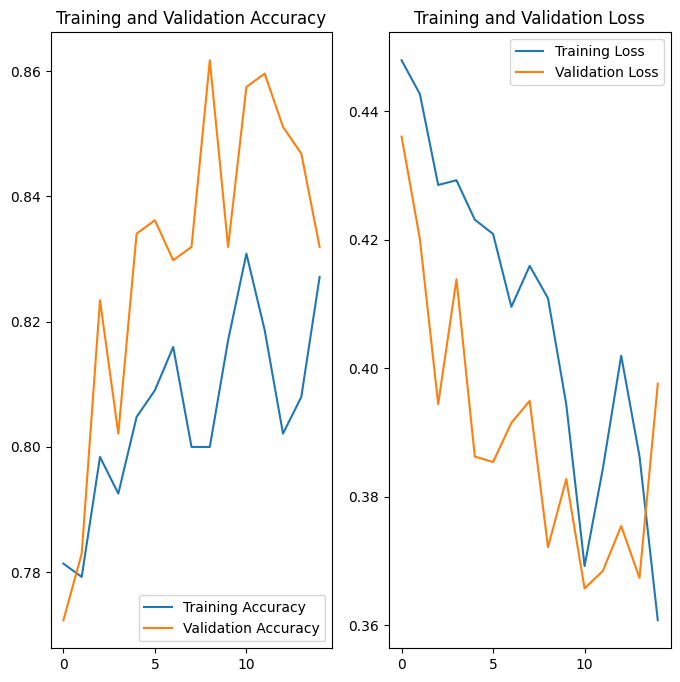

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Prediction**

In [ ]:
import os
import os.path as op

path = "/content/drive/MyDrive/Colab Notebooks/Image classification/Dataset/test/test/Osteoarthritis/9093622_1.png"
print(os.path.exists(path))

True


In [ ]:
print(Model.name)

sequential_1


1/1 [==============================] - 0s 201ms/step


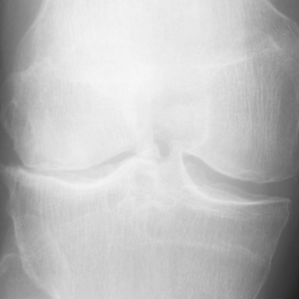

This image most likely belongs to Osteoarthritis with a 98.80 percent confidence.


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from IPython.display import Image, display

path = "/content/drive/MyDrive/Colab Notebooks/Image classification/Dataset/test/test/Osteoarthritis/9093622_1.png"
img_height, img_width = 180, 180

img = keras.preprocessing.image.load_img(path, target_size=(img_height, img_width))

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = Model.predict(img_array)
score = tf.nn.softmax(predictions[0])
display(Image(filename=path))
print("This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score)))

# **GUI (Gradio)**

In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.9/287.9 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 k

In [ ]:
import gradio as gr

In [ ]:
import numpy as np                            
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
import pathlib

In [ ]:
import os
import os.path as op

path = "/content/drive/MyDrive/Colab Notebooks/Image classification/Dataset/Valid/Valid"
print(os.path.exists(path))

True


In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
image = gr.inputs.Image(shape=(180,180))

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
